In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torchsummary import summary
from collections import OrderedDict

In [2]:
cuda = torch.cuda.is_available()

# CIFAR Dataset

In [3]:
batch_size = 32
valid_size = 0.2

# Data augmentation & transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip image on its horizontal axis
    transforms.RandomRotation(10), # randomly rotate the image by 10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
path = '../data'
# Training data
trainset = datasets.CIFAR10(root=path, download=True, train=True, transform=transform)

num_train = len(trainset) # total number of data examples
indices = list(range(num_train)) # indices for each example
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train)) # split to determine training set and validation set
train_idx, valid_idx = indices[split:], indices[:split] # Indices for the training and validation set

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Creating the DataLoader for training and validation set
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)

testset = datasets.CIFAR10(root=path, download=True, train=False, transform=transform)
#testset = datasets.FashionMNIST(path, download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)# Dataloader

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


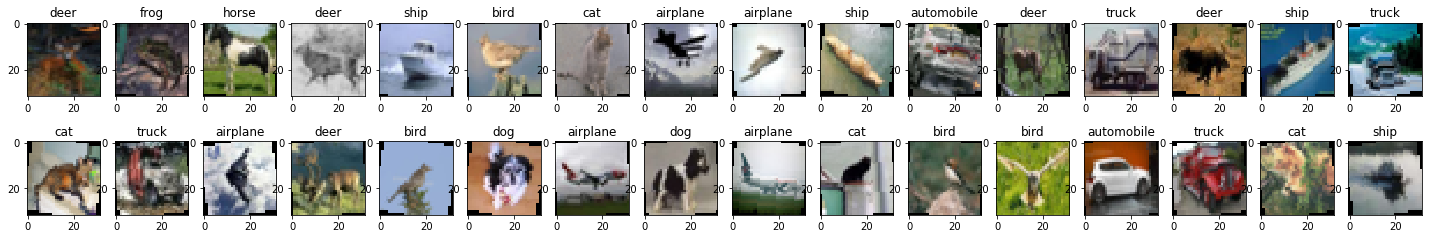

In [5]:
images, labels = next(iter(trainloader))
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for i in range(32):
    ax = fig.add_subplot(2, 32/2, i+1)
    ax.imshow(np.transpose(images[i]/2 + 0.5, (1,2,0))) # Unnormalise before plotting
    ax.set_title(classes[labels[i]])

In [6]:
images.shape

(32, 3, 32, 32)

# Capsule Network

Architecture:
1. A Convolutional Encoder
    1. Convolution layer
    2. Capsules layers
2. A fully-connected Decoder

In [7]:
# 1st Convolution Layer
class Conv_Layer(nn.Module):
    def __init__ (self, in_channels, out_channels, kernel_size=9, stride=1, padding=0):
        '''
        Inputs:
        in_channels --> Number of channels of the image, i.e. gray scale = 1, rgb = 3, etc
        out_channels --> Number of filters
        kernel_size, stride, padding --> hyperparameters for the filter and convolution
        '''
        
        super(Conv_Layer, self).__init__()
        
        # Define Convolution layer -- following the original Capsule Network paper 
        self.conv = nn.Conv2d(in_channels, out_channels,
                             kernel_size=kernel_size, stride=stride, padding=padding)
        
    def forward(self, x):
        '''
        Traditional Convolutional layer
        
        Inputs:
        x --> Image, batch_size x n_channels x height x width
        
        Outputs:
        conv_output --> feature matrix, batch_size x out_channels x * x *
        '''
        
        # Apply ReLU
        conv_output = F.relu(self.conv(x)) # 24x24
        return conv_output

In [8]:
# 1st Capsule Layer
class Capsule_Layer(nn.Module):
    def __init__(self, num_capsules, in_channels, out_channels, kernel_size=9, stride=2, padding=0):
        '''
        Inputs:
        num_capsules --> Specify number of capsules in the layer
        in_channels --> number of channels from the previous layer, i.e. number of filters used in the conv layer
        out_channels --> number of filters to use in the convolutional layers in each capsule
        kernel_size, stride, padding --> hyperparameters for the filters and convolutions
        '''
        
        super(Capsule_Layer, self).__init__()
        
        # Define a convolutional layer for each capsule
        self.caps = nn.ModuleList([nn.Conv2d(in_channels, out_channels,
                                            kernel_size=kernel_size, stride=stride, padding=padding)])
        self.caps.extend([nn.Conv2d(in_channels, out_channels,
                                   kernel_size=kernel_size, stride=stride, padding=padding) for _ in range(num_capsules-1)])
        # assign layer hyperparameters
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
    def forward(self, x):
        '''
        Calculates the output vectors for the capsule layer
        
        Inputs:
        x --> feature matrix from the previous layer, Conv Layer, batch_size x out_channels x * x *
        
        Outputs:
        u --> Output vector, batch_size x matrix_dimensions(flatten conv feature matrix) x number of capsules
        '''
        
        batch_size, _, h, _ = x.size() # batch size
        # size after convolution
        h = int(((h-self.kernel_size+2*self.padding)/self.stride) + 1)
        # Run capsule & reshape into the output vector
        # num_capsule x batch_size x mat_dims x 1
        u = [cap(x).view(batch_size, self.out_channels*h*h, 1) for cap in self.caps]
        # stack into batch_size x mat_dims x num_capsules
        u = torch.cat(u, dim=-1)
        u_squash = self.squash(u) # normalise
        
        return u_squash
        
    @staticmethod
    def squash(u):
        '''
        Convert the magnitude of the output vectors to values between 0 to 1 as they represent a probability
        
        Inputs:
        u --> output vector from capsule layer, batch_size x mat_dims x num_capsules
        
        Outputs:
        squashed_u --> normalised output vector, same dims
        '''
        sq_norm = (u**2).sum(dim=-1, keepdim=True) # sum the squared values of the output vector
        scale = sq_norm / (1+sq_norm) # normalisation coefficient
        squashed_u = scale*u/torch.sqrt(sq_norm)
        return squashed_u

In [9]:
class Routing_Layer(nn.Module):
    def __init__(self, num_capsules, mat_dims, in_channels, out_vector_len):
        '''
        Inputs:
        num_capsules --> Number of capsules in this layer, number of classes
        mat_dims --> dimensions of the flatten feature matrix from capsule layer
        in_channels --> Number of channels from prev layer, i.e. number of filters used
        out_vector_len --> Final vector output length
        '''
        
        super(Routing_Layer, self).__init__()
        
        # Randomly initialise W
        self.W = nn.Parameter(torch.randn(num_capsules, mat_dims, in_channels, out_vector_len))
    
    def forward(self, u):
        '''
        Calculate the parent capsule's output vector using dynamic routing
        
        Inputs:
        u --> vectors from Capsule_Layer
        
        Outputs:
        v --> parent layer output vector
        '''
        
        # Adding additional dimension
        W = self.W[:, None, :, :, :] # num_caps x 1 x mat_dims x in_channels x out_vector_len
        u = u[None, :, :, None, :] # 1 x batch_size x mat_dims x 1 x in_channels
        # calculate predicted output vector
        u_hat = torch.matmul(u, W) # num_caps x batch_size x mat_dims x 1 x out_vector_len
        
        # initialise our agreement, a, with the same size as our predicted output vector
        a = torch.zeros(u_hat.size())
        if cuda:
            a = a.cuda()
        
        # calculate our output vector for the parent capsule
        v = self.dynamic_routing(a, u_hat, loops=3) # num_caps x batch_size x 1 x 1 x out_vector_len
        return v
        
    @staticmethod
    def softmax(input_tensor, dim=1):
        '''
        Apply softmax to the output vector to calculate our coupling coefficient
        '''
        
        # transpose input - num_caps x batch_size x out_channels x 1 x mat_dims
        transposed_input = input_tensor.transpose(dim, len(input_tensor.size())-1)
        # contiguous - ensure that the transpose no longer share the same memory as the input tensor
        transposed_input = transposed_input.contiguous()
        size = transposed_input.size()
        # num_caps*batch_size*out_channels x mat_dims
        transposed_input = transposed_input.view(-1, transposed_input.size(-1))

        # calculate softmax
        softmaxed_output = F.softmax(transposed_input, dim=-1)
        # un-transpose result
        softmaxed_output = softmaxed_output.view(size).transpose(dim, len(input_tensor.size())-1)
        return softmaxed_output
    
    @staticmethod
    def squash(u):
        '''
        Convert the magnitude of the output vectors to values between 0 to 1 as they represent a probability
        
        Inputs:
        u --> output vector from capsule layer, batch_size x mat_dims x num_capsules
        
        Outputs:
        squashed_u --> normalised output vector, same dims
        '''
        sq_norm = (u**2).sum(dim=-1, keepdim=True) # sum the squared values of the output vector
        scale = sq_norm / (1+sq_norm) # normalisation coefficient
        squashed_u = scale*u/torch.sqrt(sq_norm)
        return squashed_u
    
    @classmethod
    def dynamic_routing(self, a, u_hat, loops=3):
        '''
        Perform dynamic routing between 2 capsule layers
        
        Inputs:
        a --> 'agreements', v*u-hat, num_capsules x batch_size x mat_dims x 1 x out_vector_len
        u_hat --> predicted output vector from the child capsule layer, num_caps x batch_size x 1 x 1 x out_vector_len
        loops --> number of iterations to optimise the coupling coefficient, c
        
        outputs:
        v --> output vector of the parent capsules, num_caps x batch_size x 1 x 1 x out_vector_len
        '''

        for i in range(loops):
            c = self.softmax(a, dim=2) # apply softmax to get coupling coefficients
            # Calculate output of the next layer
            v = (c*u_hat).sum(dim=2, keepdim=True) # num_caps x batch_size x 1 x 1 x out_vector_len
            v = self.squash(v) # same dimensions

            # not last iteration, we continue to update our coupling coefficients
            if i < loops-1:
                # multiply parent vectors with our predicted vectors to get new a
                a_temp = (v*u_hat).sum(dim=-1, keepdim=True) # num_caps x batch_size x mat_dims x 1 x out_vector_len
                a += a_temp # update current a

        return v # Return our calculated parent layer output

In [19]:
class Decoder_Layer(nn.Module):
    def __init__(self, input_vector_len, prev_capsules, hidden_dims):
        '''
        Inputs:
        input_vector_len --> out_vector_len from the routing layer
        prev_capsules --> number of capsules in the previous layer
        hidden_dims --> number of neurons in the fc layer
        '''
        
        super(Decoder_Layer, self).__init__()
        
        # batch_size x num_caps x out_channels
        in_dims = input_vector_len * prev_capsules
        
        # fully-connected layers
        self.fc1 = nn.Linear(in_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims*2)
        self.output = nn.Linear(hidden_dims*2, 3*32*32) # recreate og image dimensions
        
    def forward(self, x):
        '''
        Reconstruct the input image
        
        Inputs:
        x --> vectors from previous Routing_Layer
        
        Outputs:
        reconstructions --> reconstructure image matrix
        y --> scores
        '''
        # root sum squared, softmax to the output layer from the prev capsule layer
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        
        # find highest probability of class
        _, max_len_index = classes.max(dim=1)
        
        # create a sparse class matrix
        sparse_matrix = torch.eye(10) # 10 x 10 identity matrix, 10 --> number of classes
        if cuda:
            sparse_matrix = sparse_matrix.cuda()
        y = sparse_matrix.index_select(dim=0, index=max_len_index) # filter index to highest probability previously found
        
        
        # reconstruct pixels
        x = x*y[:,:,None]
        flattened_x = x.reshape(x.size(0), -1) # flatten image
        # reconstruct image vectors
        reconstructions = F.relu(self.fc1(flattened_x))
        reconstructions = F.relu(self.fc2(reconstructions))
        reconstructions = F.sigmoid(self.output(reconstructions))
        
        return reconstructions, y

# Complete Network

In [11]:
class Capsule_Network(nn.Module):
    def __init__(self):
        super(Capsule_Network, self).__init__()
        
        self.conv_layer = Conv_Layer(in_channels=3, out_channels=256, 
                                     kernel_size=9, stride=1, padding=0)
        self.cap_layer = Capsule_Layer(num_capsules=8, in_channels=256, out_channels=32, 
                                       kernel_size=9, stride=2, padding=0)
        self.routing_layer = Routing_Layer(num_capsules=10, mat_dims=32*8*8, 
                                           in_channels=8, out_vector_len=16)
        self.decoder = Decoder_Layer(input_vector_len=16, prev_capsules=10, hidden_dims=512)
        
    def forward(self, images):
        '''
        Perform feedforward for Capsule Network
        
        Inputs:
        images --> input images
        '''
        
        child_caps = self.conv_layer(images)
        child_caps = self.cap_layer(child_caps)
        parent_caps = self.routing_layer(child_caps).squeeze().transpose(0,1)
        reconstructions, y = self.decoder(parent_caps)
        return parent_caps, reconstructions, y

# Loss function 

In [20]:
class CapsuleLoss(nn.Module):
    
    def __init__(self):
        '''Constructs a CapsuleLoss module.'''
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum') # cumulative loss, equiv to size_average=False

    def forward(self, x, labels, images, reconstructions):
        '''Defines how the loss compares inputs.
           param x: digit capsule outputs
           param labels: 
           param images: the original MNIST image input data
           param reconstructions: reconstructed MNIST image data
           return: weighted margin and reconstruction loss, averaged over a batch
           '''
        batch_size = x.size(0)

        ##  calculate the margin loss   ##
        
        # get magnitude of digit capsule vectors, v_c
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)
        
        # sum the losses, with a lambda = 0.5
        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        ##  calculate the reconstruction loss   ##
        images = images.view(reconstructions.size(0), -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        # return a weighted, summed loss, averaged over a batch size
        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

# Training

In [21]:
# instantiate and print net
capsule_net = Capsule_Network()

print(capsule_net)

# move model to GPU, if available 
if cuda:
    capsule_net = capsule_net.cuda()

# custom loss
criterion = CapsuleLoss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters())

Capsule_Network(
  (conv_layer): Conv_Layer(
    (conv): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (cap_layer): Capsule_Layer(
    (caps): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (routing_layer): Routing_Layer()
  (decoder): Decoder_Layer(
    (fc1): Linear(in_features=160, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1024, bias=True)
    (output): Linear(in_features=1024, out_features=3072, bias=True)
  )
)


In [24]:
# Using a loop to train
epochs = 3
train_loss = []
valid_loss = []
min_valid_loss = np.inf

for e in range(epochs):
    running_loss_train = 0 # training loss
    running_loss_valid = 0 # validation loss
    
    for images, labels in trainloader:
        
        # reshape to feed into loss
        labels = torch.eye(10).index_select(dim=0, index=labels)
        
        images, labels = images.cuda(), labels.cuda() # moving data to gpu
        optimizer.zero_grad() # zero out gradients

        caps_output, reconstructions, y = capsule_net(images) # Forward pass
        loss = criterion(caps_output, labels, images, reconstructions) # calculate loss
        running_loss_train += loss.item()*images.size(0) # Update running training loss
        
        loss.backward() # Calculate gradients
        optimizer.step() # Update weights

    for images, labels in validloader:
        # reshape to feed into loss
        labels = torch.eye(10).index_select(dim=0, index=labels)
        
        images, labels = images.cuda(), labels.cuda()
        caps_output, reconstructions, y = capsule_net(images) # get output for validation set
        loss = criterion(caps_output, labels, images, reconstructions) # calculate loss of validation set
        running_loss_valid += loss.item()*images.size(0) # update running validation loss
    
    # Compute loss
    running_loss_train = running_loss_train/len(trainloader)
    running_loss_valid = running_loss_valid/len(validloader)
    
    # Store loss for this epoch    
    valid_loss.append(running_loss_valid)
    train_loss.append(running_loss_train)

    print(f"Epochs: {int(e+1)}/{int(epochs)} --- Training loss: {running_loss_train} --- Validation loss: {running_loss_valid}")
    
    if running_loss_valid <= min_valid_loss:
        print(f'Validation loss decreased by {min_valid_loss - running_loss_valid}. Saving model---')
        torch.save(capsule_net.state_dict(), '../models/capsuleNetworkCIFAR.pt')
        min_valid_loss = running_loss_valid

Epochs: 1/3 --- Training loss: 31.006878015136717 --- Validation loss: 30.252725235570352
Validation loss decreased by inf. Saving model---
Epochs: 2/3 --- Training loss: 29.62503260345459 --- Validation loss: 29.40134782760669
Validation loss decreased by 0.851377407963664. Saving model---
Epochs: 3/3 --- Training loss: 28.653403828430175 --- Validation loss: 28.290368802250384
Validation loss decreased by 1.110979025356304. Saving model---


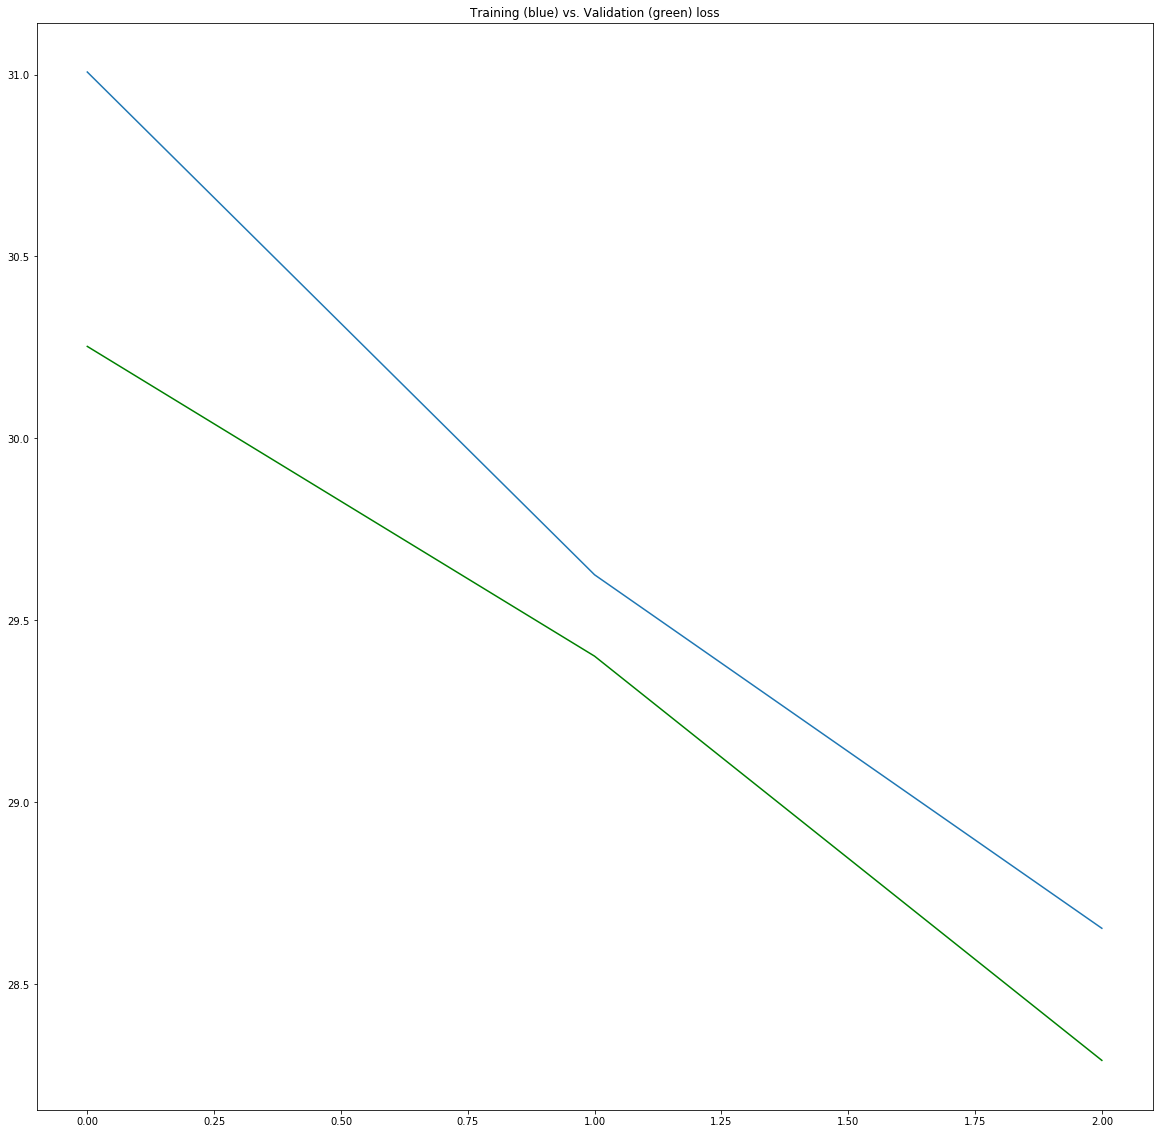

In [25]:
# Plot training loss vs validation loss
plt.figure(figsize=(20,20))
sns.lineplot(y=train_loss, x=range(epochs))
plt.plot(range(epochs), valid_loss, color='green')
plt.title('Training (blue) vs. Validation (green) loss')
plt.show()

In [27]:
capsule_net.load_state_dict(torch.load('../models/capsuleNetworkCIFAR.pt'))

<All keys matched successfully>

In [34]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
# 10 classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

capsule_net.eval() # prep model for *evaluation*. 'lock' weights

for images, labels in testloader:
    # reshape to feed into loss
    labels = torch.eye(10).index_select(dim=0, index=labels)

    images, labels = images.cuda(), labels.cuda() # moving data to gpu

    caps_output, reconstructions, y = capsule_net(images) # Forward pass
    loss = criterion(caps_output, labels, images, reconstructions) # calculate loss
    test_loss += loss.item() # update test loss

    _, pred = torch.max(y.data.cpu(), 1) # model outputs probabilities. Convert max as the predicted class (most likely)
    _, labels = torch.max(labels.data.cpu(), 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred))) # Compare y-hat with y
    # calculate test accuracy for each object class
    for i in range(images.shape[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.027489

Test Accuracy of     0: 66% (668/1000)
Test Accuracy of     1: 76% (762/1000)
Test Accuracy of     2: 54% (544/1000)
Test Accuracy of     3: 43% (435/1000)
Test Accuracy of     4: 58% (586/1000)
Test Accuracy of     5: 48% (488/1000)
Test Accuracy of     6: 68% (686/1000)
Test Accuracy of     7: 66% (665/1000)
Test Accuracy of     8: 76% (763/1000)
Test Accuracy of     9: 68% (686/1000)

Test Accuracy (Overall): 62% (6283/10000)


# References
Orginal Capsule Network Paper - https://arxiv.org/pdf/1710.09829.pdf

Intro to Deep Learning with PyTorch from Udacity
- https://github.com/cezannec/capsule_net_pytorch/blob/master/Capsule_Network.ipynb